In [1]:
zero_frac = 0.25
m_frac = 0.6
p_frac = 0.6
correction = 0.2
top_crop, bottom_crop, left_crop, right_crop = 60, 25, 0, 0
layers = 2
BATCHES = 32
EPOCHS = 5

## Build Log

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
driving_log = pd.read_csv('data/driving_log.csv', usecols=['center', 'left', 'right', 'steering'])
driving_log.shape

(27834, 4)

In [4]:
driving_log.head()

,center,left,right,steering
0,data/data22/IMG/center_2017_03_18_12_40_55_930...,data/data22/IMG/left_2017_03_18_12_40_55_930.jpg,data/data22/IMG/right_2017_03_18_12_40_55_930.jpg,0.0
1,data/data22/IMG/center_2017_03_18_12_40_56_003...,data/data22/IMG/left_2017_03_18_12_40_56_003.jpg,data/data22/IMG/right_2017_03_18_12_40_56_003.jpg,0.0
2,data/data22/IMG/center_2017_03_18_12_40_56_074...,data/data22/IMG/left_2017_03_18_12_40_56_074.jpg,data/data22/IMG/right_2017_03_18_12_40_56_074.jpg,0.0
3,data/data22/IMG/center_2017_03_18_12_40_56_148...,data/data22/IMG/left_2017_03_18_12_40_56_148.jpg,data/data22/IMG/right_2017_03_18_12_40_56_148.jpg,0.0
4,data/data22/IMG/center_2017_03_18_12_40_56_219...,data/data22/IMG/left_2017_03_18_12_40_56_219.jpg,data/data22/IMG/right_2017_03_18_12_40_56_219.jpg,0.0


In [5]:
driving_log['steering'].describe()

count    27834.000000
mean         0.002097
std          0.428305
min         -1.000000
25%         -0.035237
50%          0.000000
75%          0.043641
max          1.000000
Name: steering, dtype: float64

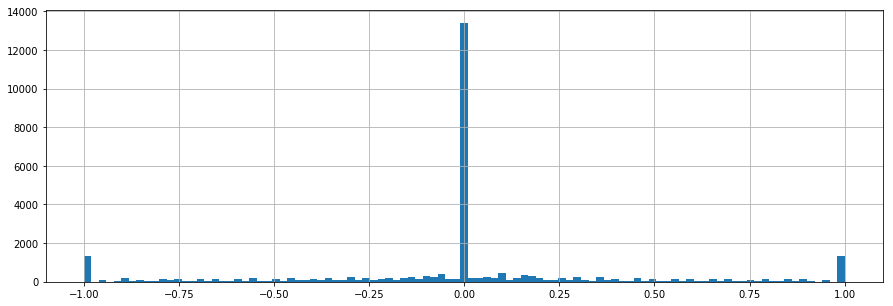

In [6]:
_ = driving_log['steering'].hist(bins=101, figsize=(15,5))

In [7]:
def undersample(log, value, frac):
    log_nonvalue = log[log['steering']!=value]
    log_value = log[log['steering']==value]
    
    if len(log_value)>0:
        log_value = log_value.sample(frac=frac)
    
    log = log_value.append(log_nonvalue)
    log = log.reset_index(drop=True)
    return log

In [8]:
driving_log = undersample(driving_log, 0, zero_frac)
driving_log = undersample(driving_log, -1, m_frac)
driving_log = undersample(driving_log, 1, p_frac)

In [9]:
driving_log['steering'].describe()

count    16846.000000
mean         0.002633
std          0.490203
min         -1.000000
25%         -0.241327
50%          0.000000
75%          0.240272
max          1.000000
Name: steering, dtype: float64

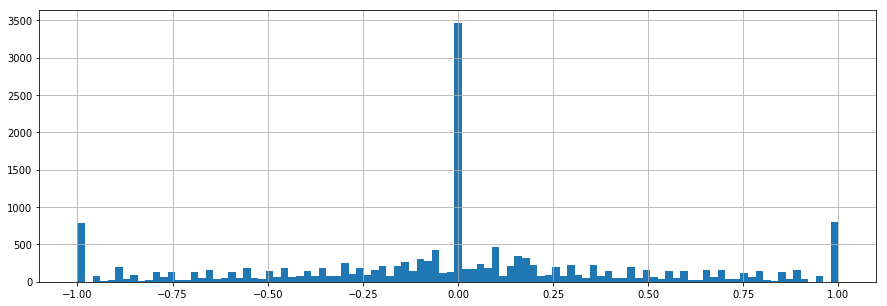

In [10]:
_ = driving_log['steering'].hist(bins=101, figsize=(15,5))

In [11]:
# Build new log taking into account correction for left and right camera images 
def augment_left_right(driving_log, correction):
    log = pd.DataFrame({'image':driving_log['center']
                                .append(driving_log['left'])
                                .append(driving_log['right']),
                        'steering':driving_log['steering']
                                .append(driving_log['steering'] + correction)
                                .append(driving_log['steering'] - correction)})

    #log = log[(log['steering']>=-1)&(log['steering']<=1)]
    return log

In [12]:
log = augment_left_right(driving_log, correction)

log.head()

,image,steering
0,data/data22/IMG/center_2017_03_18_12_49_25_345...,1.0
1,data/data2back/IMG/center_2017_03_18_13_59_48_...,1.0
2,data/data22/IMG/center_2017_03_18_12_41_29_918...,1.0
3,data/data2back/IMG/center_2017_03_18_14_00_03_...,1.0
4,data/data22/IMG/center_2017_03_18_12_44_16_020...,1.0


In [13]:
log['steering'].describe()

count    50538.000000
mean         0.002633
std          0.516679
min         -1.200000
25%         -0.273673
50%          0.000000
75%          0.287688
max          1.200000
Name: steering, dtype: float64

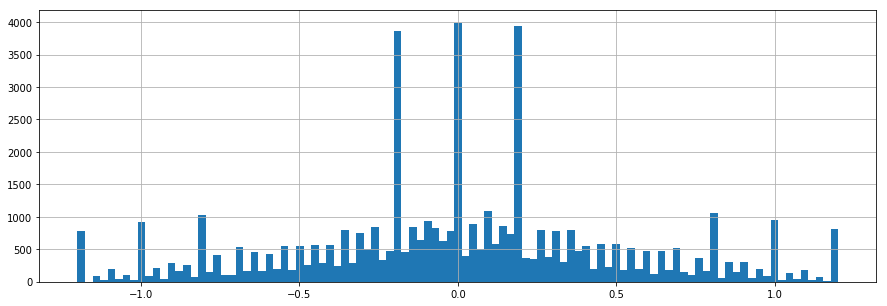

In [14]:
_ = log['steering'].hist(bins=101, figsize=(15,5))

In [15]:
# Shuffle final log DataFrame
log = log.sample(frac=1).reset_index(drop=True)  

## Build Training and Validation Data

In [16]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D

from sklearn.model_selection import train_test_split
import sklearn
%matplotlib inline

Using TensorFlow backend.


In [17]:
# Train / Validation split
train_log, validation_log = train_test_split(log, test_size=0.2)

train_log = train_log.reset_index(drop=True)
validation_log = validation_log.reset_index(drop=True)

log.shape, train_log.shape, validation_log.shape

((50538, 2), (40430, 2), (10108, 2))

In [18]:
# Image preprocessing (except normalization and cropping that are done in CNN layers)
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1:]
    
    return image

In [19]:
# Get X,y from the log. Augmentation with flipped images is applied
def get_data(log):    
    images = []
    steerings = []
    
    for _, row in log.iterrows():
        filename = row['image'].strip()
        image = preprocess(mpimg.imread(filename))
        image_flip = cv2.flip(image, 1)
        if layers==1:
            image_flip = image_flip[:,:,None]
        
        steering = row['steering']

        images.extend([image, image_flip])
        steerings.extend([steering, -steering])

    X, y = np.array(images), np.array(steerings)
    X, y = sklearn.utils.shuffle(X, y)
    
    return X, y

In [20]:
def generator(sample_log, batch_size):
    n_rows = len(sample_log)
    while 1: # Loop forever so the generator never terminates
        sample_log = sample_log.sample(frac=1).reset_index(drop=True)  #shuffle sample_log DataFrame
        
        for offset in range(0, n_rows, batch_size):
            batch_log = sample_log[offset : offset + batch_size]

            X, y = get_data(batch_log)
            
            yield X, y 

In [21]:
# Train and Validation generators
train_generator = generator(train_log, batch_size=BATCHES)
validation_generator = generator(validation_log, batch_size=BATCHES)

## Compile and train the model

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,layers)))
model.add(Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)), input_shape=(160,320,layers)))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))



In [ ]:
model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_log),
                                     validation_data = validation_generator, 
                                     nb_val_samples=len(validation_log),
                                     nb_epoch=EPOCHS,
                                     verbose=0)

model.save('model.h5')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))